In [1]:

%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
import jax
from dataclasses import dataclass
import jax.numpy as jnp
import jax.random as jr

import tensorflow_probability.substrates.jax.bijectors as tfb

#with install_import_hook("gpjax", "beartype.beartype"):
import gpjax as gpx
from gpjax.distributions import GaussianDistribution
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]

key = jr.PRNGKey(123)

import optax as ox
import tensorflow_probability.substrates.jax.bijectors as tfb

# custom bits
from gpjax.dataset import VerticalDataset
from gpjax.kernels.stationary.rbf import OrthogonalRBF, OrthogonalRBFUnif
from gpjax.gps import CustomAdditiveConjugatePosterior, VerticalSmoother
from gpjax.objectives import CustomConjugateMLL, CustomELBO, custom_variational_expectation
from gpjax.optim_utils import optim_builder, zero_grads


# 100_000 entries sampled across time/lat/lon over first day of data

## X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"


## X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"


## static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)Anisotropy of sub-gridscale orography"

2"Standard deviation of sub-gridscale orography"

3"Slope of sub-gridscale orography"

## Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

# plev are
1000.,   2000.,   3000.,   5000.,   7000.,  10000., 15000.,
20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,80000.,  85000.,  90000.,  92500.,  95000.,  97500., 100000.


In [11]:
# load data
X2d = jnp.array(jnp.load("../data/ERA/NPY_DATA/X2d_sample.npy"), dtype=jnp.float64) # [N, D]
X3d = jnp.array(jnp.load("../data/ERA/NPY_DATA/X3d_sample.npy"), dtype=jnp.float64) # [N, D]
Xstatic = jnp.array(jnp.load("../data/ERA/NPY_DATA/XStatic_sample.npy"), dtype=jnp.float64) # [N, D]
Y = jnp.array(jnp.load("../data/ERA/NPY_DATA/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)


# random shuffle
X2d = jr.permutation(key, X2d)
X3d = jr.permutation(key, X3d)
Xstatic = jr.permutation(key, Xstatic)
Y = jr.permutation(key, Y)

# look at ERA5 rain
Y = Y[:,0:1]  




# just keep the "prognostic" 3d inputs that joe considered (for now)
# RH, tehta_e^+, theta_e, theta_e^*
names_3d =  ["K,","RH", "q", "gh", "wind_z","wind_m","theta","tehta_e", "theta_e+", "theta_e*", "plume"]
idx_3d = [i for i in range(len(names_3d))]
# idx_3d = [1, 7, 8, 9]
names_3d = [names_3d[i] for i in idx_3d]
X3d = X3d[:,idx_3d,:]


# # also use his "normalisatopm" for sigma_o
sigma_o = jnp.where(Xstatic[:,0]<0.5, 0.0, 1.0+jnp.log(1+Xstatic[:,2])) # optimize threshold?
Xstatic = Xstatic.at[:,2].set(sigma_o)
names_static = ["LSM","O_angle","O_sd","O_slope"]
idx_static = [i for i in range(len(names_static))]
# idx_static = [0]
#idx_static = []
names_static = [names_static[i] for i in idx_static]
Xstatic = Xstatic[:,idx_static]


names_2d = ["K_surface","flux_s","flux_l","moisture","CRH"]
idx_2d =[i for i in range(len(names_2d))]
idx_2d = [1,2,3,4]
names_2d = [names_2d[i] for i in idx_2d]
X2d = X2d[:,idx_2d]


#remove all pressure levels below 500 hPA
lowest_idx =  11  # 7
print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")
X3d = X3d[:, :, lowest_idx:]
pressure_levels = pressure[:,lowest_idx:]



# remove any entries with nan
X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
X2d_nan_idx = jnp.isnan(X2d).any(axis=1)
Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
Y_nan_idx = jnp.isnan(Y).any(axis=1)
any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
no_nan = ~ any_nan
print(f"Removed {any_nan.sum()} entries with nan")
X2d = X2d[no_nan,:]
X3d = X3d[no_nan,:,:]
Xstatic = Xstatic[no_nan,:]
Y = Y[no_nan,:]


# # remove no rain days
# print(f"Removed {(Y[:,0]==0).sum()} entries with zero rain")
# X3d = X3d[Y[:,0]>0,:]
# X2d = X2d[Y[:,0]>0,:]
# Xstatic = Xstatic[Y[:,0]>0,:]
# Y = Y[Y[:,0]>0,:]


# also log Y
# print(f"Applied log transform to Y")
# Y = jnp.log(Y-jnp.min(Y)+1e-12)
print(f"then standardized Y as Gaussian")
Y_mean = jnp.mean(Y)
Y_std = jnp.std(Y)
Y = (Y - Y_mean) / Y_std



# standardize inputs 
print("standardized inputs to be Gaussian")
X3d_std = jnp.std(X3d, axis=(0))
X3d_mean = jnp.mean(X3d,axis=(0))
X3d = (X3d - X3d_mean[None,:,:]) / X3d_std[None,:,:]
X2d_std = jnp.std(X2d, axis=0)
X2d_mean = jnp.mean(X2d,axis=0)
X2d = (X2d - X2d_mean) / X2d_std
Xstatic_std = jnp.std(Xstatic, axis=0)
Xstatic_mean = jnp.mean(Xstatic,axis=0)
Xstatic = (Xstatic - Xstatic_mean) / Xstatic_std

# print("standardized inputs with max and min")
# X3d_min = jnp.min(X3d, axis=(0))
# X3d_max = jnp.max(X3d,axis=(0))
# X3d = (X3d_max - X3d) / (X3d_max - X3d_min)
# X2d_min = jnp.min(X2d, axis=0)
# X2d_max = jnp.max(X2d,axis=0)
# X2d = (X2d_max - X2d) / (X2d_max - X2d_min)
# Xstatic_min = jnp.min(Xstatic, axis=0)
# Xstatic_max = jnp.max(Xstatic,axis=0)
# Xstatic = (Xstatic_max - Xstatic) / (Xstatic_max - Xstatic_min)





# look at all data but 1_000 test

N_test = 100
N_train = len(X2d) - N_test 
print(f"Using {N_train} training and {N_test} testing points!")
num_2d_variables= X2d.shape[1]
num_3d_variables= X3d.shape[1]
num_static_variables= Xstatic.shape[1]
num_not_3d_variables = num_2d_variables + num_static_variables
num_variables = num_2d_variables + num_3d_variables + num_static_variables
print(f"using {num_static_variables} static variables")
print(f"using {num_2d_variables} 2d variables")
print(f"using {num_3d_variables} 3d variables")
names = names_3d + names_2d + names_static
print(f"using variables with names {names}")

Removed all pressure levels below [50000.] hPa
Removed 38 entries with nan
then standardized Y as Gaussian
standardized inputs to be Gaussian
Using 99862 training and 100 testing points!
using 4 static variables
using 4 2d variables
using 11 3d variables
using variables with names ['K,', 'RH', 'q', 'gh', 'wind_z', 'wind_m', 'theta', 'tehta_e', 'theta_e+', 'theta_e*', 'plume', 'flux_s', 'flux_l', 'moisture', 'CRH', 'LSM', 'O_angle', 'O_sd', 'O_slope']


In [3]:
def plot_params(model, title=""):
    if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
        model = model.posterior
    plt.figure()
    if isinstance(model.prior.kernel, gpx.kernels.AdditiveKernel):
        lengthscales = jnp.array([model.prior.kernel.kernels[i].lengthscale[0] for i in range(len(model.prior.kernel.kernels))])
    else:
        lengthscales = model.prior.kernel.lengthscale
    
    z_to_plot = jnp.linspace(jnp.min(model.smoother.Z_levels),jnp.max(model.smoother.Z_levels),100)
    smoothing_weights = model.smoother.smooth_fn(z_to_plot) 
    z_unscaled = z_to_plot * model.smoother.Z_std + model.smoother.Z_mean
    for i in range(num_3d_variables):
        plt.plot(smoothing_weights[i,:].T,z_unscaled, label=f"{names_3d[i]} with lengthscales_ {lengthscales[i]:.2f}")
    plt.legend()
    plt.title(title+f" other lengthscales are {lengthscales[num_3d_variables:]}")
    plt.gca().invert_yaxis()



def plot_interactions(model, data):
    q = model
    if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
        model = model.posterior
    plt.figure()
    idx_0 = [[]]
    idx_1 = [[i] for i in range(num_variables)]
    idx_2 = []
    for i in range(num_variables):
        for j in range(i+1,num_variables):
            idx_2.append([i,j])
    idxs = idx_0 + idx_1 + idx_2       
    sobols = model.get_sobol_indicies(data, idxs)
    sobols = sobols / jnp.sum(sobols)
    plt.plot(sobols)
    plt.title("sobol indicies (red lines between orders)")
    plt.axvline(x=1, color="red")
    plt.axvline(x=num_variables+1, color="red")
    k=10
    top_idx = jax.lax.top_k(sobols, k)[1]
    x_train = model.smoother.smooth_data(data)[0]
    posterior_dist = model.predict_additive_component(x_train[:1,:], data, [])
    mean = posterior_dist.mean() * Y_std + Y_mean
    print(f"cst term is {mean}")
    for idx in top_idx:
        chosen_idx = idxs[idx]
        plt.figure()
        num_plot = 1_000 if len(chosen_idx)==1 else 10_000
        x_plot = jr.uniform(key, (num_plot, num_variables), minval=jnp.min(x_train, axis=0), maxval=jnp.max(x_train, axis=0))
        posterior_dist = model.predict_additive_component(x_plot, data, chosen_idx)
        mean = posterior_dist.mean() * Y_std + Y_mean
        std = jnp.sqrt(posterior_dist.variance())* Y_std
        

        if len(chosen_idx)==1:
            plt.scatter(x_plot[:,chosen_idx[0]],mean, color="blue") 
            plt.scatter(x_plot[:,chosen_idx[0]],mean+ 1.96*std, color="red") 
            plt.scatter(x_plot[:,chosen_idx[0]],mean- 1.96*std, color="red") 
            plt.scatter(x_train[:,chosen_idx[0]],jnp.zeros_like(x_train[:,chosen_idx[0]]), color="green")
            plt.xlim([jnp.min(x_train[:,chosen_idx[0]]),jnp.max(x_train[:,chosen_idx[0]])])
            if isinstance(q, gpx.variational_families.AbstractVariationalFamily):
                z = q.inducing_inputs
                plt.scatter(z[:,chosen_idx[0]],jnp.zeros_like(z[:,chosen_idx[0]]), color="black")
        elif len(chosen_idx)==2:
            col = plt.scatter(x_plot[:,chosen_idx[0]],x_plot[:,chosen_idx[1]],c=mean)
            plt.scatter(x_train[:,chosen_idx[0]],x_train[:,chosen_idx[1]], color="green")
            plt.xlim([jnp.min(x_train[:,chosen_idx[0]]),jnp.max(x_train[:,chosen_idx[0]])])
            plt.ylim([jnp.min(x_train[:,chosen_idx[1]]),jnp.max(x_train[:,chosen_idx[1]])])
            plt.colorbar(col)
        plt.title(f"variable {[names[i] for i in chosen_idx]} with sobol index {sobols[idx]}")


# def eval(lengthscales, scales):
#     base_kernels= [gpx.kernels.RBF(lengthscale=jnp.array([lengthscales[0]]), active_dims=[0]),
#                 gpx.kernels.RBF(lengthscale=jnp.array([lengthscales[1]]), active_dims=[1]),
#                 gpx.kernels.RBF(lengthscale=jnp.array([lengthscales[2]]), active_dims=[2]),
#                 ]
#     max_interaction = 2
#     kernel = gpx.kernels.AdditiveKernel(kernels=base_kernels,interaction_variances=scales**2, max_interaction_depth=max_interaction)
#     x = jnp.array([[1.0,3.0,5.0],[3.0,9.0,7.0],[5.0,7.0,2.0]])
#     return kernel.gram(x).to_dense()



# print("K for l=0.4,0.12,5.8 and sigma=2.5,0.7,1.3 is")
# print(eval(jnp.array([0.4,0.12,5.8]), jnp.array([2.5,0.7,1.3])))
# f = lambda l : eval(l, jnp.array([2.5,0.7,1.3]))
# print(f"dk/dl for l=0.4,0.12,5.8 and sigma=2.5,0.7,1.3 is") 
# print(jax.jacfwd(f)(jnp.array([0.4,0.12,5.8])).T)
# f = lambda sigma : eval(jnp.array([0.4,0.12,5.8]), sigma)
# print(f"dk/dsigma for l=0.4,0.12,5.8 and sigma=2.5,0.7,1.3 is") 
# print(jax.jacfwd(f)(jnp.array([2.5,0.7,1.3])).T)


In [4]:
def init_smoother(data: VerticalDataset, fit=True, use_tau=False, tau=0.1) -> VerticalSmoother:
    smoother = VerticalSmoother(
        jnp.array([[0.0]*num_3d_variables]), 
        jnp.array([[1.0]*num_3d_variables]), 
        Z_levels=pressure_levels)
    smoother_input_scale_bij = tfb.SoftClip(jnp.array(1e-1, dtype=jnp.float64),jnp.array(5.0, dtype=jnp.float64))
    smoother_mean_bij = tfb.SoftClip(jnp.array(jnp.min(smoother.Z_levels), dtype=jnp.float64),jnp.array(jnp.max(smoother.Z_levels), dtype=jnp.float64))
    smoother = smoother.replace_bijector(smoother_mean=smoother_mean_bij,smoother_input_scale=smoother_input_scale_bij)
    if fit:
        data = VerticalDataset(X3d=data.X3d,X2d = jnp.array([[]]*len(data.X3d)),Xstatic = jnp.array([[]]*len(data.X3d)), y = data.y)
        prior = init_prior(data, additive=False)
        likelihood = init_likelihood(data, fix_noise=False)
        posterior = CustomAdditiveConjugatePosterior(prior=prior, likelihood=likelihood, smoother=smoother)
        optim =  ox.adam(learning_rate=1e-1)
        if use_tau:
            obj = jax.jit(CustomConjugateMLL(negative=True, use_tau=True, tau=tau))
        else:
            obj = jax.jit(CustomConjugateMLL(negative=True))
        opt_posterior, history = gpx.fit(
            model=posterior,
            objective=obj,
            train_data=data,
            optim=optim,
            num_iters=200,
            key=jr.PRNGKey(42),
            safe=False,
        )
        print(f"kernel variance is {opt_posterior.prior.kernel.variance}")
        plot_params(opt_posterior, "init_smoother with rbf")
        plt.figure()
        plt.plot(history)
        return opt_posterior.smoother
    else:
        return smoother


def init_prior(data, additive=True):
    lengthscale_bij = tfb.SoftClip(jnp.array(1e-1, dtype=jnp.float64),jnp.array(1e2, dtype=jnp.float64))
    variance_bij = tfb.SoftClip(jnp.array(1e-5, dtype=jnp.float64),jnp.array(1e2, dtype=jnp.float64))
    if additive:
        base_kernels = [gpx.kernels.RBF(lengthscale=jnp.array([1.0]), active_dims=[i]).replace_bijector(lengthscale=lengthscale_bij).replace_trainable(variance=False) for i in range(num_variables)]
        #base_kernels= [OrthogonalRBF(lengthscale=jnp.array([1.]), active_dims=[i]).replace_bijector(lengthscale=lengthscale_bij) for i in range(data.dim)]
        #base_kernels= [OrthogonalRBFUnif(lengthscale=jnp.array([1.]), active_dims=[i]).replace_bijector(lengthscale=lengthscale_bij) for i in range(data.dim)]
        max_interaction = 2
        kernel = gpx.kernels.AdditiveKernel(kernels=base_kernels,interaction_variances=jnp.array([1.0/(max_interaction+1.0)]*(max_interaction+1)), max_interaction_depth=max_interaction).replace_bijector(interaction_variances=variance_bij)
        #kernel = kernel.replace_trainable(interaction_variances=False)
    else:
        kernel = gpx.kernels.RBF(lengthscale= jnp.array([1.0]*data.dim)).replace_bijector(lengthscale=lengthscale_bij).replace_bijector(variance=variance_bij)
    return gpx.gps.Prior(mean_function= gpx.mean_functions.Zero(), kernel = kernel)


def init_likelihood(data: VerticalDataset, fix_noise=False):
    noise_bij = tfb.SoftClip(jnp.array(1e-2, dtype=jnp.float64),jnp.array(1e1, dtype=jnp.float64))
    likelihood = gpx.likelihoods.Gaussian(num_datapoints=data.n, obs_stddev=jnp.array(0.5, dtype=jnp.float64)).replace_bijector(obs_stddev=noise_bij)
    if fix_noise:
        return likelihood.replace_trainable(obs_stddev=False)
    else:
        return likelihood







  0%|          | 0/200 [00:00<?, ?it/s]

kernel variance is 1.6411426191460947


  0%|          | 0/1000 [00:00<?, ?it/s]

noise is 0.5651448108009536
interaction vars i/88/14s [9.05386347e-05 1.92611019e-04 4.83484482e-02]


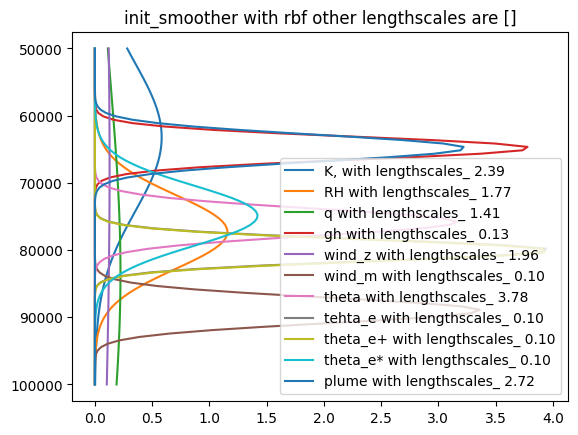

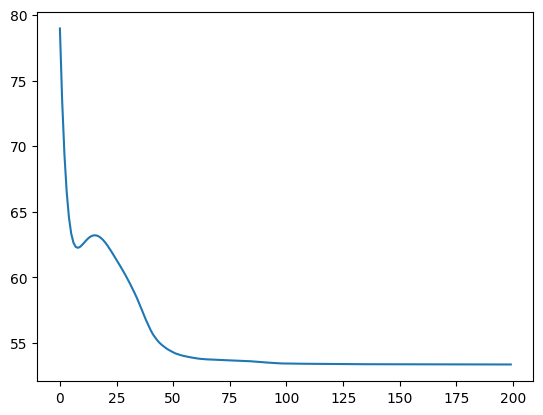

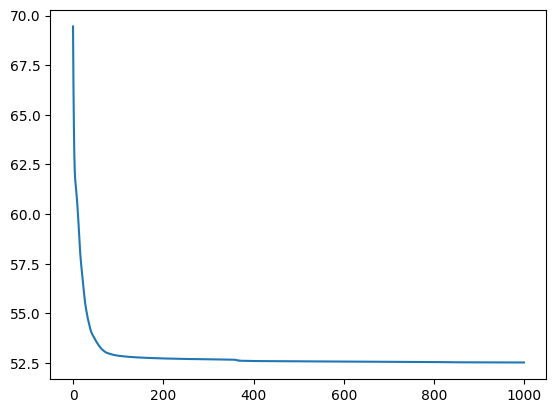

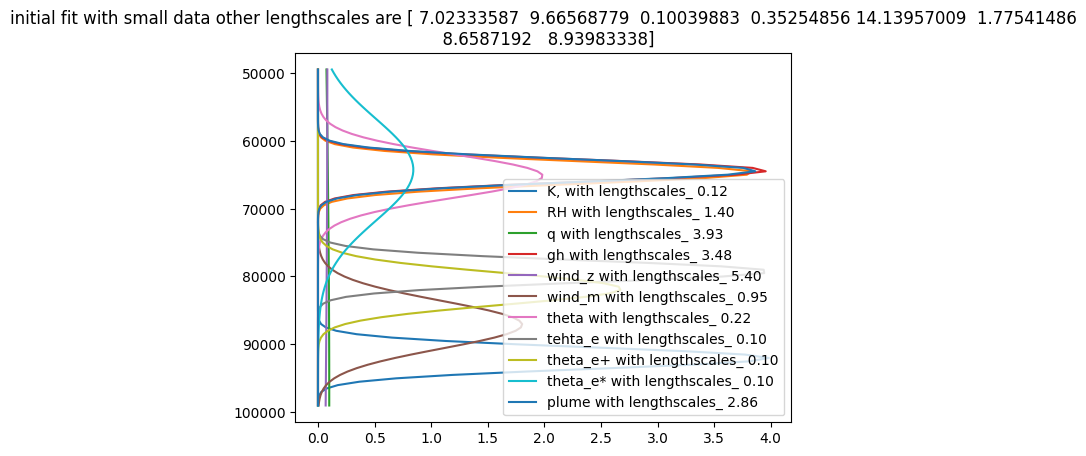

In [5]:
# prep fancy kernel for model
# first fit with small data to get init for SVGP
num_data_for_init=50
D_small = VerticalDataset(
    X2d = X2d[:num_data_for_init,:],
    X3d = X3d[:num_data_for_init,:,:],
    Xstatic = Xstatic[:num_data_for_init,:],
    y=Y[:num_data_for_init,:],
)

smoother = init_smoother(D_small, fit=True, use_tau=False, tau=1.0)
#smoother = smoother.replace_trainable(smoother_input_scale=False, smoother_mean=False)

# fit with small data

posterior = CustomAdditiveConjugatePosterior(prior=init_prior(D_small), likelihood=init_likelihood(D_small), smoother=smoother)
plt.figure()
opt_posterior, history = gpx.fit(
        model=posterior,
        objective=jax.jit(CustomConjugateMLL(negative=True, use_tau=False, tau=0.1)),
        train_data=D_small,
        optim=ox.adamw(1e-1),
        num_iters=1000,
        key=jr.PRNGKey(42),
        safe=False,
    )
plt.plot(history)
plot_params(opt_posterior, title="initial fit with small data")
print(f"noise is {opt_posterior.likelihood.obs_stddev}")
print(f"interaction vars i/88/14s {opt_posterior.prior.kernel.interaction_variances}")


cst term is [1.54482327]


<Figure size 640x480 with 0 Axes>

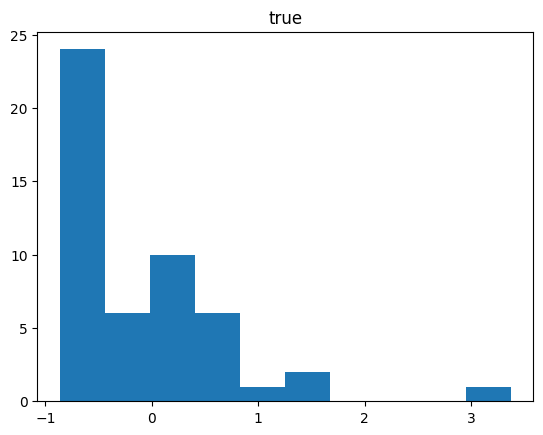

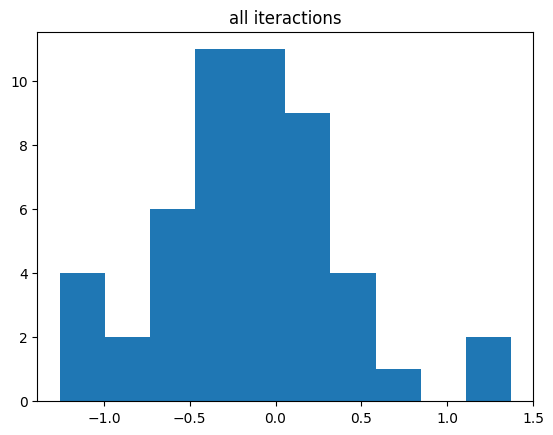

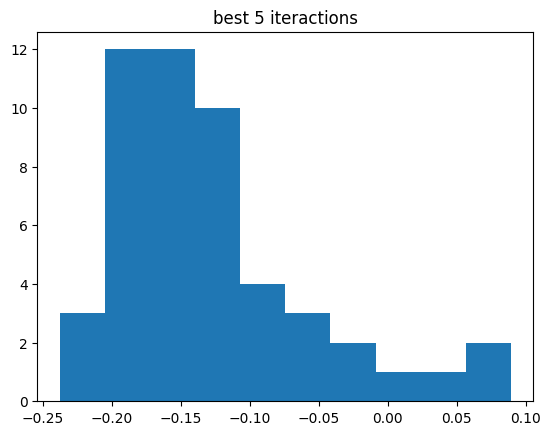

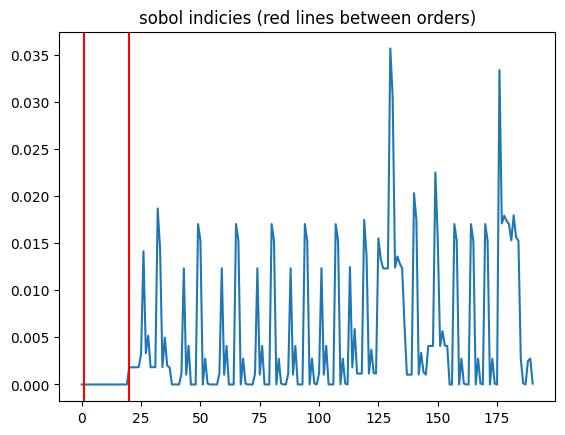

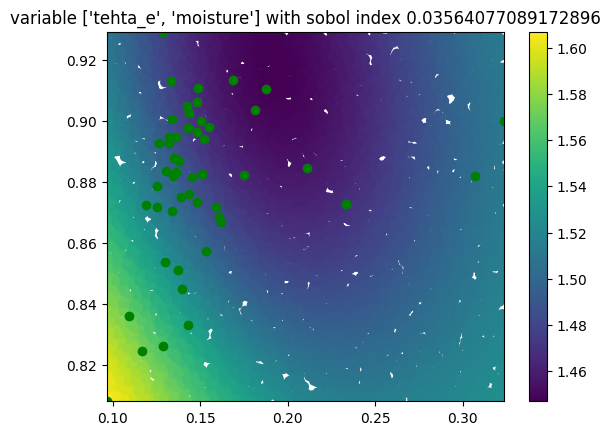

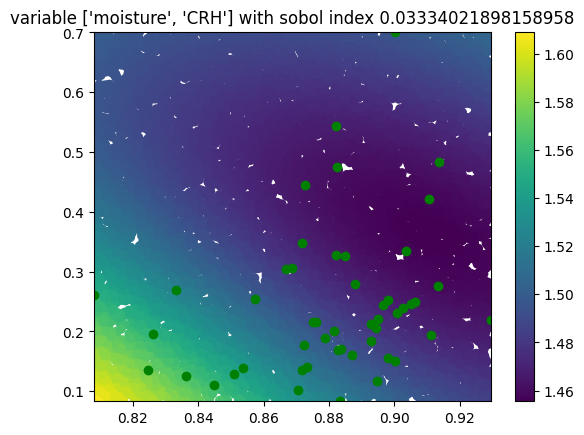

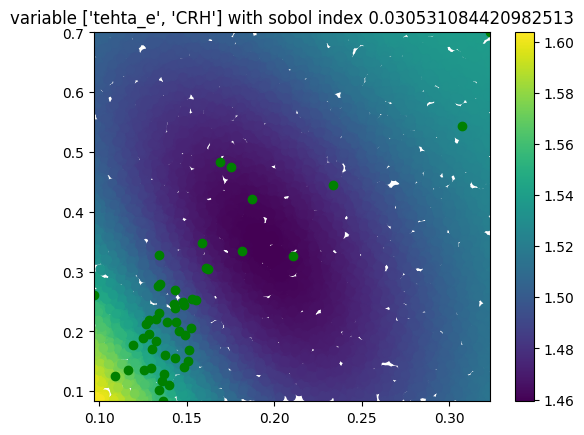

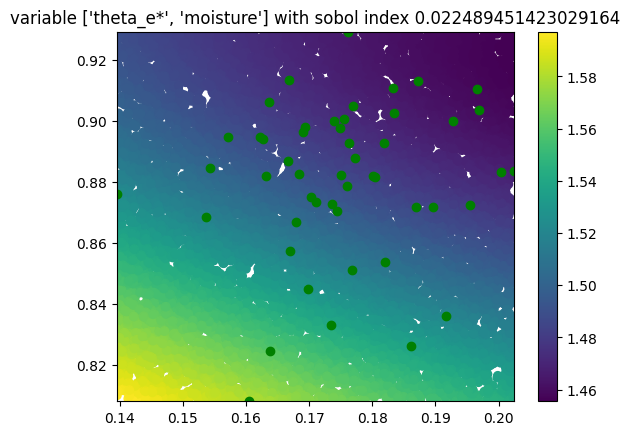

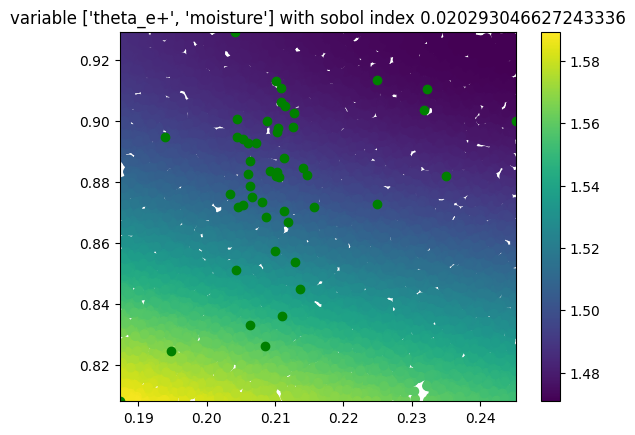

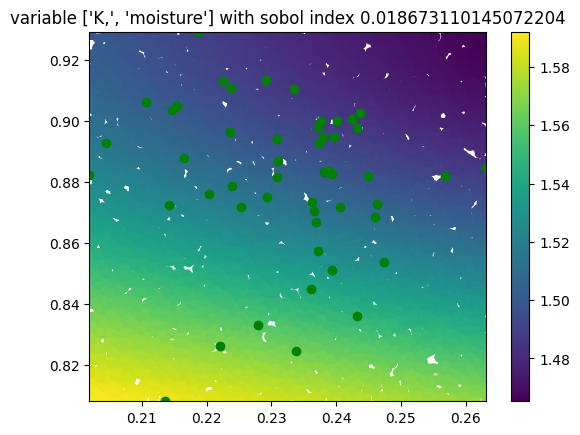

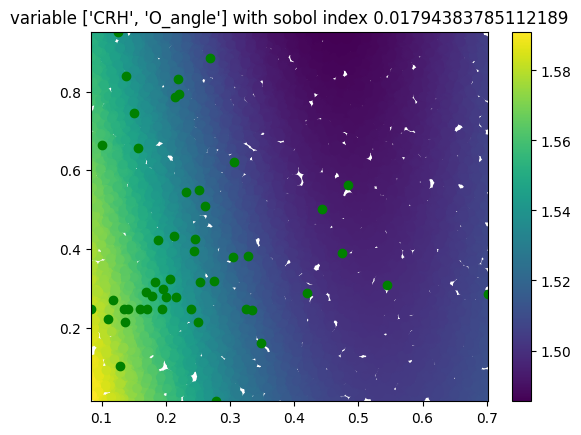

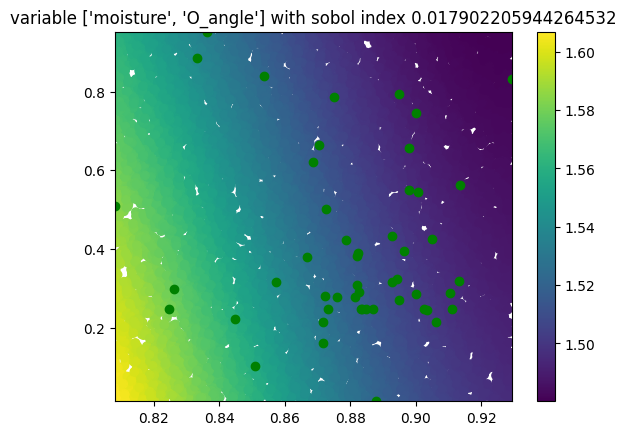

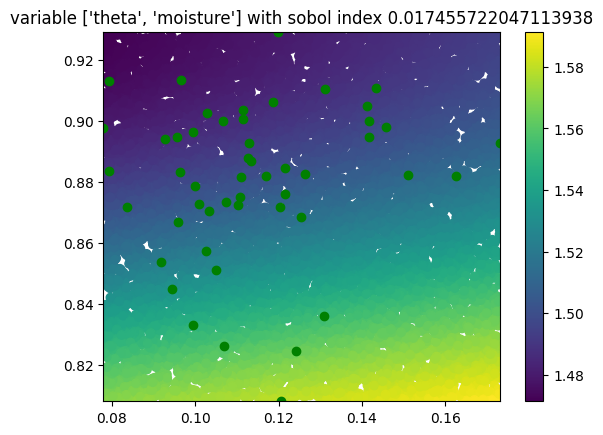

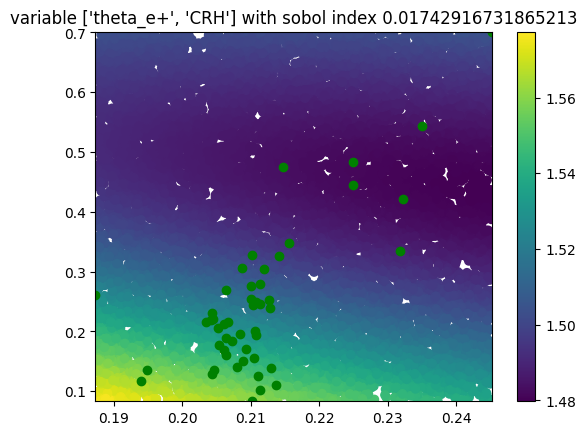

In [6]:
plot_interactions(opt_posterior, D_small)


In [7]:
# # choose inducing inputs and init SVGP
# num_inducing = 10
# #z = jr.normal(key, (num_inducing , num_variables)) # allow this
# #z = opt_posterior.smoother.smooth_data(D_small)[0] # need space filling deisng

# from scipy.stats import qmc
# sampler = qmc.Halton(d=num_variables, scramble=False, seed=1234)
# z_box = sampler.random(n=num_inducing)
# v = 0.5 + (1 - 1e-10) * (z_box - 0.5)
# z = jax.scipy.special.erfinv(2 * v - 1) * jnp.sqrt(2)



# init_posterior_at_inducing = opt_posterior.predict(z, D_small)
# D_full = VerticalDataset(
#     X2d = X2d[:N_train,:],
#     X3d = X3d[:N_train,:,:],
#     Xstatic = Xstatic[:N_train,:],
#     y=Y[:N_train,:],
# )
# # todo try whitening ?
# q = gpx.variational_families.VariationalGaussian(
#     posterior=opt_posterior, 
#     inducing_inputs=z,
#     variational_mean= init_posterior_at_inducing.mean()[:,None],
#     variational_root_covariance= jnp.eye(num_inducing, dtype=jnp.float64)#jnp.linalg.cholesky(init_posterior_at_inducing.covariance() + 1e-3 * jnp.eye(num_inducing)), # todo check this is right!
# )

# #q = q.replace_trainable(inducing_inputs=False)
# # q = q.replace_trainable(variational_mean=False)
# # q = q.replace_trainable(variational_root_covariance=False)

# objective = jax.jit(CustomELBO(negative=True))

# optim_pytree = q.replace(
#     posterior = ox.adamw(1e-1), 
#     variational_mean = ox.adamw(1e-2),
#     variational_root_covariance = ox.adamw(1e-2), 
#     inducing_inputs= ox.adamw(1e-1),
#     )

# optim = optim_builder(optim_pytree)

# opt_q, history = gpx.fit(
#     model=q,
#     objective=objective,
#     train_data=D_full,
#     optim=optim,
#     num_iters=1000,
#     key=jr.PRNGKey(42),
#     batch_size=512,
#     safe=False,
# )

# plt.figure()
# plt.plot(jnp.log(history))
# plot_params(opt_q, title="full fit")

In [8]:
# plot_interactions(opt_q, D_small)
